# TVM 分析

导入可视化工具：

In [1]:
from graphviz import Digraph
from IPython.display import display_svg
from tvm.contrib.relay_viz import RelayVisualizer
from tvm.contrib.relay_viz.dot import DotPlotter


class Visualizer(RelayVisualizer):
    def graph(self, graph_name):
        return self._plotter._name_to_graph[graph_name]

    def display(self, graph_name):
        graph = self.graph(graph_name)
        return graph.digraph

    def display_all(self, format="svg",
                    filename=None,
                    directory="images"):
        root_graph = Digraph(format=format,
                             filename=filename,
                             directory=directory)
        for graph in self._plotter._name_to_graph.values():
            root_graph.subgraph(graph.digraph)
        return root_graph


graph_attr = {"color": "red"}
node_attr = {"color": "blue"}
edge_attr = {"color": "black"}

# 添加颜色
dot_plotter = DotPlotter(
    graph_attr=graph_attr,
    node_attr=node_attr,
    edge_attr=edge_attr)

## 计算 MACs

参考：[How to get number of MAC counts from IRModule](https://discuss.tvm.apache.org/t/how-to-get-number-of-mac-counts-from-irmodule/8960/3)

In [2]:
import mxnet as mx
import numpy as np
from mxnet.gluon.model_zoo.vision import get_model

from tvm import relay
from tvm.relay.analysis import get_total_mac_number


shape_dict = {"data": (1, 3, 224, 224)}
block = get_model("resnet18_v1", pretrained=True)
mod, params = relay.frontend.from_mxnet(block, shape_dict)
mod = relay.transform.InferType()(mod)
compute_count = get_total_mac_number(mod["main"])
macs = compute_count/(2 ** 30)
print(f"MACs: {macs:.2g}GB")

MACs: 1.7GB


[17:14:54] /media/pc/data/4tb/lxw/books/tvm/src/relay/analysis/mac_count.cc:172: This pass only counts MACs in direct conv2d, conv2d_transpose, dense, and batch_matmul ops


## 校准数据

{func}`tvm.relay.analysis.get_calibration_data` 获得给定 Relay 图的校准数据。

该 Pass 使用 graph executor 来获取模块的校准数据，其中包括每个函数的输入和输出值。返回的数据使用每个函数的 `GlobalVar` 作为键。用户可以使用 `inputs` 或 `outputs` 作为键来进一步访问输入和输出。

以下是一些限制：

- 输入模块(graph)不能有控制流。
- 每个函数的输入参数不能是元组（输出可以是元组）。
- 只处理 top-level 函数（即不处理嵌套函数）。
- 只处理设置了 `Compiler` 属性的函数。

参数：

- `mod` （{class}`tvm.IRModule`）：收集标定数据的输入模块。
- `data` （`Dict[str, NDArray]`）：运行的模块的输入数据。
        
返回校准数据：

- `data`：`Dict[tvm.relay.GlobalVar, Dict[str, NDArray]]`

下面以示例解释。

### 创建包含两个子图的模块

首先，构建单个子图：

In [3]:
from tvm.ir import IRModule

mod = IRModule()

x0 = relay.var("x0", shape=(8, 8))
y0 = relay.var("y0", shape=(8, 8))
z0 = x0 + y0
z1 = x0 - y0
z2 = relay.Tuple((z0, z1))
f0 = relay.Function([x0, y0], z2)
f0 = f0.with_attr("Compiler", "test_graph")
g0 = relay.GlobalVar("g0")
mod[g0] = f0
mod = relay.transform.InferType()(mod)

查看 `mod` 结构：

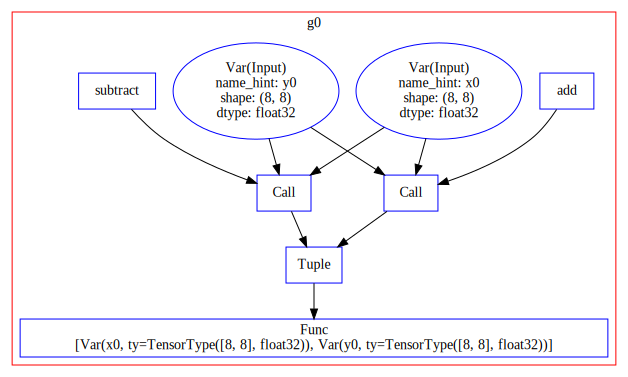

In [4]:
viz = Visualizer(mod, plotter=dot_plotter)
graph = viz.display_all()
display_svg(graph)

添加新的子图：

In [5]:
x1 = relay.var("x1", shape=(8, 8))
y1 = relay.var("y1", shape=(8, 8))
z1 = x1 - y1
f1 = relay.Function([x1, y1], z1)
f1 = f1.with_attr("Compiler", "test_graph")
g1 = relay.GlobalVar("g1")
mod[g1] = f1
mod = relay.transform.InferType()(mod)

查看完整计算图：

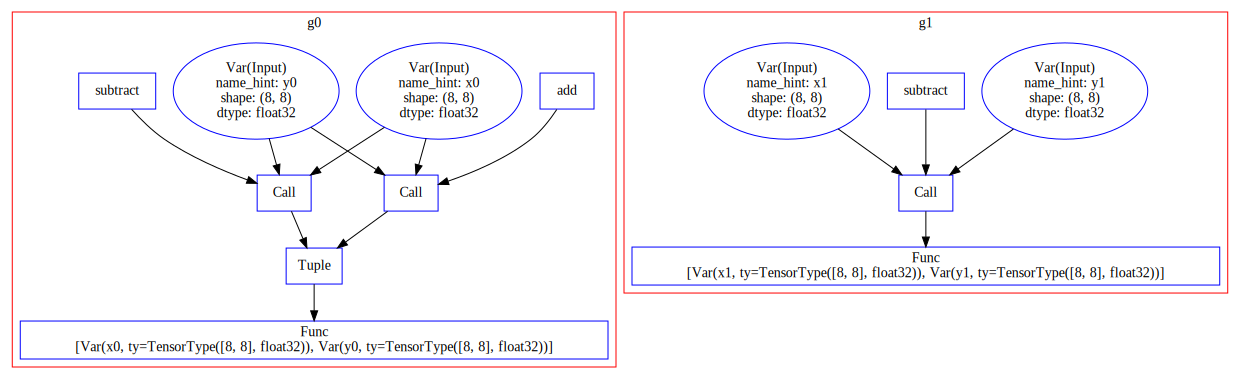

In [6]:
viz = Visualizer(mod, plotter=dot_plotter)
graph = viz.display_all()
display_svg(graph)

将两个子图建立联系：

In [7]:
x = relay.var("x", shape=(8, 8))
y = relay.var("y", shape=(8, 8))
z = relay.var("z", shape=(8, 8))
c0 = relay.Call(g0, [x, y])
c1 = relay.Call(g1, [relay.TupleGetItem(c0, 0), z])
fm = relay.Function([x, y, z], c1)
mod["main"] = fm
mod = relay.transform.InferType()(mod)

仅仅查看 `main` 函数：

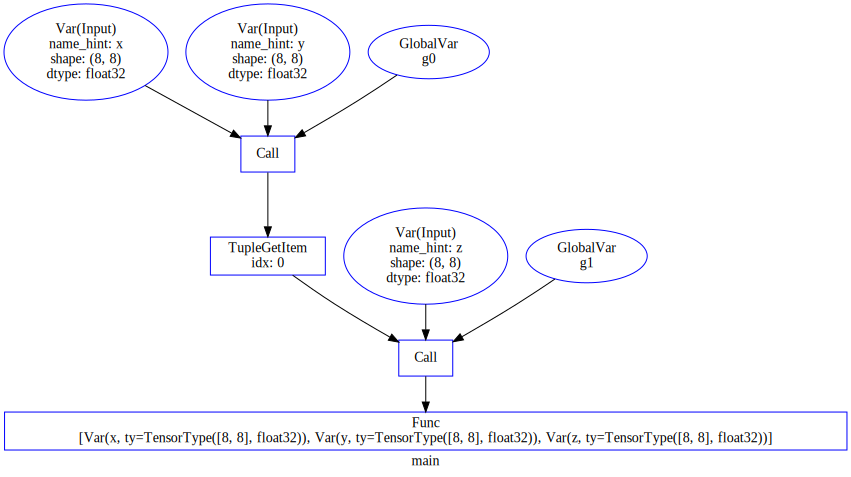

In [8]:
viz = Visualizer(mod, plotter=dot_plotter)
graph = viz.display("main")
display_svg(graph)

模拟数据：

In [9]:
from tvm.relay.analysis import get_calibration_data

x_data = np.random.rand(8, 8).astype("float32")
y_data = np.random.rand(8, 8).astype("float32")
z_data = np.random.rand(8, 8).astype("float32")
data = get_calibration_data(mod, {"x": x_data, "y": y_data, "z": z_data})

定义审查函数：

In [10]:
def check_data_size(mod, data):
    assert len(data) == len(mod.functions) - 1
    for key, value in mod.functions.items():
        if key.name_hint != "main":
            assert len(data[key]["inputs"]) == len(value.params)
            if isinstance(value.body, relay.Tuple):
                assert len(data[key]["outputs"]) == len(value.body.fields)
            else:
                assert len(data[key]["outputs"]) == 1

核对数据：

In [11]:
check_data_size(mod, data)
np.testing.assert_allclose(data[g0]["inputs"][0].numpy(), x_data)
np.testing.assert_allclose(data[g0]["inputs"][1].numpy(), y_data)
np.testing.assert_allclose(data[g0]["outputs"][0].numpy(), x_data + y_data)
np.testing.assert_allclose(data[g0]["outputs"][1].numpy(), x_data - y_data)
np.testing.assert_allclose(data[g1]["inputs"][0].numpy(), x_data + y_data)
np.testing.assert_allclose(data[g1]["inputs"][1].numpy(), z_data)
np.testing.assert_allclose(data[g1]["outputs"][0].numpy(), x_data + y_data - z_data)

## 注解区域

{func}`tvm.relay.op.annotation.compiler_begin`(data, compiler) {func}`tvm.relay.op.annotation.compiler_end`(data, compiler) 注解释表达式，以指示它是将由给定 `compiler` 处理的区域的开始与结束。参数如下：

- `data` （{data}`tvm.relay.Expr`）：要注解的表达式。
- `compiler` （ Str）：用于生成带注解区域的代码的编译器。

In [12]:
from tvm.relay.op.annotation import compiler_begin, compiler_end

def check_region(region_set, target, args, nodes, rets):
    region = region_set.get_region(args[0])
    assert region
    assert target == region.target
    assert set(args) == set(region.args)
    assert set(nodes) == set(region.nodes)
    assert set(rets) == set(region.rets)

In [13]:
data = relay.var("data", shape=(10, 10))
cb_1 = compiler_begin(data, "test_target")
O_1 = relay.abs(cb_1)
ce_1 = compiler_end(O_1, "test_target")
ce_2 = compiler_end(O_1, "test_target")
cb_2 = compiler_begin(ce_1, "test_target")
O_2 = relay.nn.relu(cb_2)
ce_3 = compiler_end(O_2, "test_target")
cb_d = compiler_begin(ce_2, "default")
X = relay.tanh(cb_d)
ce_d = compiler_end(X, "default")
cb_3 = compiler_begin(ce_3, "test_target")
cb_4 = compiler_begin(ce_d, "test_target")
O_3 = relay.add(cb_3, cb_4)
ce_4 = compiler_end(O_3, "test_target")
diamond = relay.Function([data], ce_4)

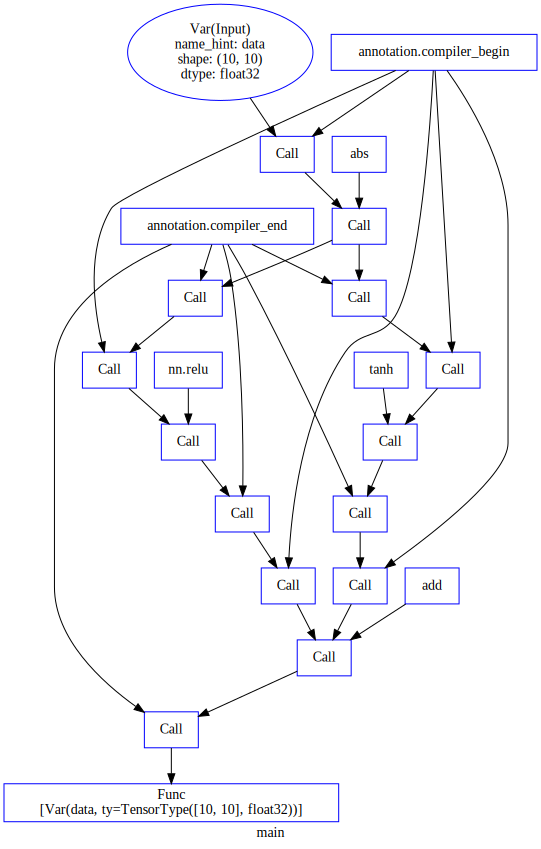

In [18]:
mod = IRModule.from_expr(diamond)
viz = Visualizer(mod, plotter=dot_plotter)
graph = viz.display("main")
display_svg(graph)

In [ ]:
# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements.  See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership.  The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License.  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied.  See the License for the
# specific language governing permissions and limitations
# under the License.
# pylint: disable=no-else-return, unidiomatic-typecheck, invalid-name
import tvm
from tvm import relay
from tvm.relay.op.annotation import compiler_begin, compiler_end


def check_region(region_set, target, args, nodes, rets):
    region = region_set.get_region(args[0])
    assert region
    assert target == region.target
    assert set(args) == set(region.args)
    assert set(nodes) == set(region.nodes)
    assert set(rets) == set(region.rets)


def test_region_set_creator_diamond():
    data = relay.var("data", shape=(10, 10))
    cb_1 = compiler_begin(data, "test_target")
    O_1 = relay.abs(cb_1)
    ce_1 = compiler_end(O_1, "test_target")
    ce_2 = compiler_end(O_1, "test_target")
    cb_2 = compiler_begin(ce_1, "test_target")
    O_2 = relay.nn.relu(cb_2)
    ce_3 = compiler_end(O_2, "test_target")
    cb_d = compiler_begin(ce_2, "default")
    X = relay.tanh(cb_d)
    ce_d = compiler_end(X, "default")
    cb_3 = compiler_begin(ce_3, "test_target")
    cb_4 = compiler_begin(ce_d, "test_target")
    O_3 = relay.add(cb_3, cb_4)
    ce_4 = compiler_end(O_3, "test_target")
    diamond = relay.Function([data], ce_4)

    region_set = relay.analysis.AnnotatedRegionSet(
        diamond, relay.op.get("annotation.compiler_begin"), relay.op.get("annotation.compiler_end")
    )
    assert len(region_set) == 4
    check_region(
        region_set,
        "test_target",
        [cb_1],
        [cb_1, O_1, ce_1, ce_2],
        [ce_1, ce_2],
    )
    check_region(
        region_set,
        "test_target",
        [cb_2],
        [cb_2, O_2, ce_3],
        [ce_3],
    )
    check_region(
        region_set,
        "default",
        [cb_d],
        [cb_d, X, ce_d],
        [ce_d],
    )
    check_region(
        region_set,
        "test_target",
        [cb_3, cb_4],
        [cb_3, cb_4, O_3, ce_4],
        [ce_4],
    )


def test_region_set_creator_merged():
    data = relay.var("data", shape=(10, 10))
    cb_1 = compiler_begin(data, "test_target")
    O_1 = relay.abs(cb_1)
    ce_2 = compiler_end(O_1, "test_target")
    O_2 = relay.nn.relu(O_1)
    ce_3 = compiler_end(O_2, "test_target")
    cb_d = compiler_begin(ce_2, "default")
    X = relay.tanh(cb_d)
    ce_d = compiler_end(X, "default")
    cb_3 = compiler_begin(ce_3, "test_target")
    cb_4 = compiler_begin(ce_d, "test_target")
    O_3 = relay.add(cb_3, cb_4)
    O_4 = relay.add(cb_3, cb_4)
    O_5 = relay.Tuple([O_3, O_4])
    ce_4 = compiler_end(O_5, "test_target")
    merged = relay.Function([data], ce_4)

    region_set = relay.analysis.AnnotatedRegionSet(
        merged, relay.op.get("annotation.compiler_begin"), relay.op.get("annotation.compiler_end")
    )
    assert len(region_set) == 3
    check_region(
        region_set,
        "test_target",
        [cb_1],
        [cb_1, O_1, O_2, ce_2, ce_3],
        [ce_2, ce_3],
    )
    check_region(
        region_set,
        "default",
        [cb_d],
        [cb_d, X, ce_d],
        [ce_d],
    )
    check_region(
        region_set,
        "test_target",
        [cb_3, cb_4],
        [cb_3, cb_4, O_3, O_4, O_5, ce_4],
        [ce_4],
    )


if __name__ == "__main__":
    test_region_set_creator_diamond()
    test_region_set_creator_merged()
